In [1]:
%load_ext autoreload
%autoreload 2
from copy import deepcopy
import os
os.chdir("/home/jakob/doktor/projects/EnsembleUncertainty/code")
"""Learing "logit" distribution in regression example"""
from pathlib import Path
from datetime import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import torch

from src.dataloaders import gaussian_sinus, one_dim_regression
import src.utils as utils
from src.distilled import logits_probability_distribution, gauss_mix
from src.ensemble import simple_regressor, ensemble

import src.metrics as metrics
import src.loss as custom_loss
from src import utils

LOGGER = logging.getLogger(__name__)
EXPERIMENT_NAME = "regression_logits"

# Settings
class Args():
    pass
args = Args()
args.seed = 1
args.gpu = True
args.log_dir = Path("./logs")

args.log_level = logging.INFO
args.retrain = True

args.num_ensemble_members=10
args.num_epochs=100
args.lr = 0.01


In [2]:
def make_plots(distilled_model, data):
    test_loader = torch.utils.data.DataLoader(data,
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=0)

    predictions = np.zeros((data.n_samples, distilled_model.output_size))
    all_x = np.zeros((data.n_samples, 1))
    all_y = np.zeros((data.n_samples, 1))

    idx = 0
    for batch in test_loader:
        inputs, targets = batch

        predictions[idx * test_loader.batch_size:(idx + 1) * test_loader.batch_size, :, :] = \
            distilled_model.predict(inputs, t=None).data.numpy()

        all_x[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = inputs
        all_y[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = targets

        idx += 1

    plt.scatter(np.squeeze(all_x), np.squeeze(all_y), label="Data", marker=".")

    plt.errorbar(np.squeeze(all_x),
                 predictions[:, 0],
                 np.sqrt(predictions[:, 1]),
                 label="Distilled model predictions",
                 marker=".",
                 ls="none")

    plt.legend()
    plt.show()


In [3]:
log_file = Path("{}_{}.log".format(
    EXPERIMENT_NAME,
    datetime.now().strftime("%Y%m%d_%H%M%S")))
utils.setup_logger(log_path=Path.cwd() / args.log_dir / log_file,
                   log_level=args.log_level)
LOGGER.info("Args: {}".format(args))
device = utils.torch_settings(args.seed, args.gpu)
LOGGER.info("Creating dataloader")
data = gaussian_sinus.GaussianSinus(range_=(-3, 3), store_file=Path("none"))

input_size = 1
ensemble_output_size = 2
layer_sizes = [1, 10, 10, ensemble_output_size] # Mean and variance
args.num_ensemble_members = 10
args.num_epochs=150
args.lr = 0.001
args.log_level = logging.INFO
train_loader = torch.utils.data.DataLoader(data,
                                           batch_size=32,
                                           shuffle=True)

prob_ensemble = ensemble.Ensemble(ensemble_output_size)
for _ in range(args.num_ensemble_members):

    model = simple_regressor.Model(layer_sizes=layer_sizes,
                                 device=device,
                                 variance_transform=utils.variance_linear_asymptote(),
                                 loss_function=custom_loss.gaussian_neg_log_likelihood_1d)
    model.optimizer = torch.optim.Adam(model.parameters(),
                                         lr=args.lr)
    #model.switch_active_network("mu")
    prob_ensemble.add_member(model)
squared_error_metric = metrics.Metric(name="MSE",
                                      function=metrics.mean_squared_error)
prob_ensemble.add_metrics([squared_error_metric])
prob_ensemble.train(train_loader, args.num_epochs)

2020-02-17 17:05:23,709 INFO  root            - Log at /home/jakob/doktor/projects/EnsembleUncertainty/code/logs/regression_logits_20200217_170523.log
2020-02-17 17:05:23,710 INFO  __main__        - Args: <__main__.Args object at 0x7f47e4c6ee10>
2020-02-17 17:05:23,719 INFO  __main__        - Creating dataloader
2020-02-17 17:05:23,719 INFO  GaussianSinus   - Sampling new data
2020-02-17 17:05:23,994 INFO  Model           - Moving model to device: cuda
2020-02-17 17:05:23,995 INFO  Model           - Using variance transform: <lambda>
2020-02-17 17:05:25,874 WARNING Ensemble        - Is subclass check disabled
2020-02-17 17:05:25,874 INFO  Ensemble        - Adding <class 'src.ensemble.simple_regressor.Model'> to ensemble
2020-02-17 17:05:25,875 INFO  Model           - Moving model to device: cuda
2020-02-17 17:05:25,876 INFO  Model           - Using variance transform: <lambda>
2020-02-17 17:05:25,878 WARNING Ensemble        - Is subclass check disabled
2020-02-17 17:05:25,878 INFO  Ens

2020-02-17 17:05:41,278 INFO  Model           - Train - Epoch 41: Loss: 0.048 MSE: 0.087
2020-02-17 17:05:41,642 INFO  Model           - Train - Epoch 42: Loss: 0.051 MSE: 0.089
2020-02-17 17:05:41,997 INFO  Model           - Train - Epoch 43: Loss: 0.047 MSE: 0.086
2020-02-17 17:05:42,357 INFO  Model           - Train - Epoch 44: Loss: 0.037 MSE: 0.085
2020-02-17 17:05:42,709 INFO  Model           - Train - Epoch 45: Loss: 0.038 MSE: 0.085
2020-02-17 17:05:43,057 INFO  Model           - Train - Epoch 46: Loss: 0.041 MSE: 0.085
2020-02-17 17:05:43,403 INFO  Model           - Train - Epoch 47: Loss: 0.042 MSE: 0.086
2020-02-17 17:05:43,754 INFO  Model           - Train - Epoch 48: Loss: 0.024 MSE: 0.084
2020-02-17 17:05:44,111 INFO  Model           - Train - Epoch 49: Loss: 0.032 MSE: 0.085
2020-02-17 17:05:44,462 INFO  Model           - Train - Epoch 50: Loss: 0.038 MSE: 0.085
2020-02-17 17:05:44,828 INFO  Model           - Train - Epoch 51: Loss: 0.037 MSE: 0.085
2020-02-17 17:05:45,1

2020-02-17 17:06:15,791 INFO  Model           - Train - Epoch 133: Loss: 0.006 MSE: 0.078
2020-02-17 17:06:16,169 INFO  Model           - Train - Epoch 134: Loss: 0.009 MSE: 0.080
2020-02-17 17:06:16,553 INFO  Model           - Train - Epoch 135: Loss: 0.011 MSE: 0.079
2020-02-17 17:06:16,929 INFO  Model           - Train - Epoch 136: Loss: -0.003 MSE: 0.078
2020-02-17 17:06:17,317 INFO  Model           - Train - Epoch 137: Loss: -0.004 MSE: 0.078
2020-02-17 17:06:17,713 INFO  Model           - Train - Epoch 138: Loss: 0.028 MSE: 0.080
2020-02-17 17:06:18,090 INFO  Model           - Train - Epoch 139: Loss: 0.006 MSE: 0.078
2020-02-17 17:06:18,468 INFO  Model           - Train - Epoch 140: Loss: 0.020 MSE: 0.080
2020-02-17 17:06:18,838 INFO  Model           - Train - Epoch 141: Loss: 0.020 MSE: 0.080
2020-02-17 17:06:19,209 INFO  Model           - Train - Epoch 142: Loss: 0.008 MSE: 0.078
2020-02-17 17:06:19,588 INFO  Model           - Train - Epoch 143: Loss: 0.003 MSE: 0.078
2020-02-

2020-02-17 17:06:50,234 INFO  Model           - Train - Epoch 75: Loss: 0.008 MSE: 0.079
2020-02-17 17:06:50,616 INFO  Model           - Train - Epoch 76: Loss: 0.023 MSE: 0.082
2020-02-17 17:06:50,988 INFO  Model           - Train - Epoch 77: Loss: 0.016 MSE: 0.081
2020-02-17 17:06:51,382 INFO  Model           - Train - Epoch 78: Loss: 0.022 MSE: 0.080
2020-02-17 17:06:51,841 INFO  Model           - Train - Epoch 79: Loss: 0.003 MSE: 0.078
2020-02-17 17:06:52,250 INFO  Model           - Train - Epoch 80: Loss: 0.019 MSE: 0.079
2020-02-17 17:06:52,628 INFO  Model           - Train - Epoch 81: Loss: 0.032 MSE: 0.081
2020-02-17 17:06:53,017 INFO  Model           - Train - Epoch 82: Loss: 0.046 MSE: 0.082
2020-02-17 17:06:53,410 INFO  Model           - Train - Epoch 83: Loss: 0.011 MSE: 0.081
2020-02-17 17:06:53,802 INFO  Model           - Train - Epoch 84: Loss: 0.009 MSE: 0.078
2020-02-17 17:06:54,163 INFO  Model           - Train - Epoch 85: Loss: 0.013 MSE: 0.078
2020-02-17 17:06:54,5

2020-02-17 17:07:24,705 INFO  Model           - Train - Epoch 16: Loss: 0.179 MSE: 0.105
2020-02-17 17:07:25,084 INFO  Model           - Train - Epoch 17: Loss: 0.157 MSE: 0.101
2020-02-17 17:07:25,470 INFO  Model           - Train - Epoch 18: Loss: 0.151 MSE: 0.102
2020-02-17 17:07:25,837 INFO  Model           - Train - Epoch 19: Loss: 0.125 MSE: 0.098
2020-02-17 17:07:26,202 INFO  Model           - Train - Epoch 20: Loss: 0.113 MSE: 0.098
2020-02-17 17:07:26,584 INFO  Model           - Train - Epoch 21: Loss: 0.125 MSE: 0.098
2020-02-17 17:07:26,944 INFO  Model           - Train - Epoch 22: Loss: 0.128 MSE: 0.099
2020-02-17 17:07:27,332 INFO  Model           - Train - Epoch 23: Loss: 0.107 MSE: 0.097
2020-02-17 17:07:27,703 INFO  Model           - Train - Epoch 24: Loss: 0.079 MSE: 0.095
2020-02-17 17:07:28,066 INFO  Model           - Train - Epoch 25: Loss: 0.119 MSE: 0.096
2020-02-17 17:07:28,422 INFO  Model           - Train - Epoch 26: Loss: 0.088 MSE: 0.095
2020-02-17 17:07:28,8

2020-02-17 17:07:58,790 INFO  Model           - Train - Epoch 108: Loss: 0.023 MSE: 0.082
2020-02-17 17:07:59,141 INFO  Model           - Train - Epoch 109: Loss: 0.026 MSE: 0.083
2020-02-17 17:07:59,502 INFO  Model           - Train - Epoch 110: Loss: 0.070 MSE: 0.084
2020-02-17 17:07:59,869 INFO  Model           - Train - Epoch 111: Loss: 0.030 MSE: 0.082
2020-02-17 17:08:00,219 INFO  Model           - Train - Epoch 112: Loss: 0.030 MSE: 0.083
2020-02-17 17:08:00,589 INFO  Model           - Train - Epoch 113: Loss: 0.016 MSE: 0.082
2020-02-17 17:08:00,949 INFO  Model           - Train - Epoch 114: Loss: 0.010 MSE: 0.081
2020-02-17 17:08:01,317 INFO  Model           - Train - Epoch 115: Loss: 0.023 MSE: 0.084
2020-02-17 17:08:01,693 INFO  Model           - Train - Epoch 116: Loss: 0.013 MSE: 0.081
2020-02-17 17:08:02,067 INFO  Model           - Train - Epoch 117: Loss: 0.014 MSE: 0.082
2020-02-17 17:08:02,460 INFO  Model           - Train - Epoch 118: Loss: 0.021 MSE: 0.082
2020-02-17

2020-02-17 17:08:34,098 INFO  Model           - Train - Epoch 49: Loss: 0.050 MSE: 0.088
2020-02-17 17:08:34,490 INFO  Model           - Train - Epoch 50: Loss: 0.038 MSE: 0.086
2020-02-17 17:08:34,874 INFO  Model           - Train - Epoch 51: Loss: 0.051 MSE: 0.087
2020-02-17 17:08:35,256 INFO  Model           - Train - Epoch 52: Loss: 0.047 MSE: 0.086
2020-02-17 17:08:35,652 INFO  Model           - Train - Epoch 53: Loss: 0.038 MSE: 0.087
2020-02-17 17:08:36,036 INFO  Model           - Train - Epoch 54: Loss: 0.039 MSE: 0.086
2020-02-17 17:08:36,441 INFO  Model           - Train - Epoch 55: Loss: 0.048 MSE: 0.089
2020-02-17 17:08:36,844 INFO  Model           - Train - Epoch 56: Loss: 0.052 MSE: 0.086
2020-02-17 17:08:37,241 INFO  Model           - Train - Epoch 57: Loss: 0.044 MSE: 0.087
2020-02-17 17:08:37,650 INFO  Model           - Train - Epoch 58: Loss: 0.059 MSE: 0.090
2020-02-17 17:08:38,038 INFO  Model           - Train - Epoch 59: Loss: 0.032 MSE: 0.085
2020-02-17 17:08:38,4

2020-02-17 17:09:10,190 INFO  Model           - Train - Epoch 141: Loss: 0.006 MSE: 0.079
2020-02-17 17:09:10,579 INFO  Model           - Train - Epoch 142: Loss: 0.003 MSE: 0.078
2020-02-17 17:09:10,966 INFO  Model           - Train - Epoch 143: Loss: -0.001 MSE: 0.078
2020-02-17 17:09:11,362 INFO  Model           - Train - Epoch 144: Loss: 0.024 MSE: 0.081
2020-02-17 17:09:11,747 INFO  Model           - Train - Epoch 145: Loss: 0.009 MSE: 0.079
2020-02-17 17:09:12,150 INFO  Model           - Train - Epoch 146: Loss: 0.002 MSE: 0.079
2020-02-17 17:09:12,547 INFO  Model           - Train - Epoch 147: Loss: 0.020 MSE: 0.082
2020-02-17 17:09:12,935 INFO  Model           - Train - Epoch 148: Loss: 0.019 MSE: 0.080
2020-02-17 17:09:13,328 INFO  Model           - Train - Epoch 149: Loss: 0.021 MSE: 0.081
2020-02-17 17:09:13,733 INFO  Model           - Train - Epoch 150: Loss: 0.001 MSE: 0.078
2020-02-17 17:09:13,733 INFO  Ensemble        - Training member 5/10
2020-02-17 17:09:14,110 INFO  

2020-02-17 17:09:44,078 INFO  Model           - Train - Epoch 83: Loss: 0.001 MSE: 0.076
2020-02-17 17:09:44,428 INFO  Model           - Train - Epoch 84: Loss: -0.010 MSE: 0.076
2020-02-17 17:09:44,774 INFO  Model           - Train - Epoch 85: Loss: 0.001 MSE: 0.077
2020-02-17 17:09:45,114 INFO  Model           - Train - Epoch 86: Loss: 0.002 MSE: 0.076
2020-02-17 17:09:45,473 INFO  Model           - Train - Epoch 87: Loss: 0.006 MSE: 0.077
2020-02-17 17:09:45,835 INFO  Model           - Train - Epoch 88: Loss: -0.008 MSE: 0.075
2020-02-17 17:09:46,207 INFO  Model           - Train - Epoch 89: Loss: -0.002 MSE: 0.077
2020-02-17 17:09:46,587 INFO  Model           - Train - Epoch 90: Loss: -0.004 MSE: 0.077
2020-02-17 17:09:46,957 INFO  Model           - Train - Epoch 91: Loss: 0.001 MSE: 0.078
2020-02-17 17:09:47,329 INFO  Model           - Train - Epoch 92: Loss: -0.003 MSE: 0.075
2020-02-17 17:09:47,715 INFO  Model           - Train - Epoch 93: Loss: -0.010 MSE: 0.075
2020-02-17 17:0

2020-02-17 17:10:17,832 INFO  Model           - Train - Epoch 24: Loss: 0.192 MSE: 0.090
2020-02-17 17:10:18,209 INFO  Model           - Train - Epoch 25: Loss: 0.189 MSE: 0.090
2020-02-17 17:10:18,577 INFO  Model           - Train - Epoch 26: Loss: 0.164 MSE: 0.086
2020-02-17 17:10:18,947 INFO  Model           - Train - Epoch 27: Loss: 0.166 MSE: 0.087
2020-02-17 17:10:19,326 INFO  Model           - Train - Epoch 28: Loss: 0.153 MSE: 0.086
2020-02-17 17:10:19,698 INFO  Model           - Train - Epoch 29: Loss: 0.154 MSE: 0.087
2020-02-17 17:10:20,081 INFO  Model           - Train - Epoch 30: Loss: 0.127 MSE: 0.083
2020-02-17 17:10:20,467 INFO  Model           - Train - Epoch 31: Loss: 0.116 MSE: 0.082
2020-02-17 17:10:20,835 INFO  Model           - Train - Epoch 32: Loss: 0.116 MSE: 0.084
2020-02-17 17:10:21,210 INFO  Model           - Train - Epoch 33: Loss: 0.114 MSE: 0.083
2020-02-17 17:10:21,573 INFO  Model           - Train - Epoch 34: Loss: 0.096 MSE: 0.082
2020-02-17 17:10:21,9

2020-02-17 17:10:51,656 INFO  Model           - Train - Epoch 116: Loss: -0.002 MSE: 0.075
2020-02-17 17:10:52,014 INFO  Model           - Train - Epoch 117: Loss: 0.009 MSE: 0.078
2020-02-17 17:10:52,384 INFO  Model           - Train - Epoch 118: Loss: -0.006 MSE: 0.075
2020-02-17 17:10:52,746 INFO  Model           - Train - Epoch 119: Loss: -0.010 MSE: 0.075
2020-02-17 17:10:53,118 INFO  Model           - Train - Epoch 120: Loss: 0.006 MSE: 0.076
2020-02-17 17:10:53,507 INFO  Model           - Train - Epoch 121: Loss: -0.006 MSE: 0.075
2020-02-17 17:10:53,898 INFO  Model           - Train - Epoch 122: Loss: -0.003 MSE: 0.076
2020-02-17 17:10:54,301 INFO  Model           - Train - Epoch 123: Loss: -0.006 MSE: 0.076
2020-02-17 17:10:54,701 INFO  Model           - Train - Epoch 124: Loss: 0.002 MSE: 0.077
2020-02-17 17:10:55,088 INFO  Model           - Train - Epoch 125: Loss: 0.011 MSE: 0.076
2020-02-17 17:10:55,509 INFO  Model           - Train - Epoch 126: Loss: 0.004 MSE: 0.077
2020

2020-02-17 17:11:26,754 INFO  Model           - Train - Epoch 57: Loss: -0.000 MSE: 0.077
2020-02-17 17:11:27,161 INFO  Model           - Train - Epoch 58: Loss: -0.001 MSE: 0.075
2020-02-17 17:11:27,559 INFO  Model           - Train - Epoch 59: Loss: 0.004 MSE: 0.077
2020-02-17 17:11:27,939 INFO  Model           - Train - Epoch 60: Loss: -0.007 MSE: 0.076
2020-02-17 17:11:28,324 INFO  Model           - Train - Epoch 61: Loss: 0.011 MSE: 0.078
2020-02-17 17:11:28,714 INFO  Model           - Train - Epoch 62: Loss: 0.006 MSE: 0.078
2020-02-17 17:11:29,121 INFO  Model           - Train - Epoch 63: Loss: 0.002 MSE: 0.077
2020-02-17 17:11:29,506 INFO  Model           - Train - Epoch 64: Loss: 0.008 MSE: 0.078
2020-02-17 17:11:29,875 INFO  Model           - Train - Epoch 65: Loss: 0.004 MSE: 0.079
2020-02-17 17:11:30,250 INFO  Model           - Train - Epoch 66: Loss: -0.005 MSE: 0.077
2020-02-17 17:11:30,630 INFO  Model           - Train - Epoch 67: Loss: 0.006 MSE: 0.077
2020-02-17 17:11:

2020-02-17 17:12:01,581 INFO  Model           - Train - Epoch 149: Loss: 0.006 MSE: 0.077
2020-02-17 17:12:01,953 INFO  Model           - Train - Epoch 150: Loss: -0.001 MSE: 0.076
2020-02-17 17:12:01,953 INFO  Ensemble        - Training member 8/10
2020-02-17 17:12:02,310 INFO  Model           - Train - Epoch 1: Loss: 1.297 MSE: 0.797
2020-02-17 17:12:02,672 INFO  Model           - Train - Epoch 2: Loss: 1.131 MSE: 0.598
2020-02-17 17:12:03,020 INFO  Model           - Train - Epoch 3: Loss: 1.036 MSE: 0.505
2020-02-17 17:12:03,380 INFO  Model           - Train - Epoch 4: Loss: 0.967 MSE: 0.436
2020-02-17 17:12:03,735 INFO  Model           - Train - Epoch 5: Loss: 0.902 MSE: 0.361
2020-02-17 17:12:04,086 INFO  Model           - Train - Epoch 6: Loss: 0.838 MSE: 0.293
2020-02-17 17:12:04,451 INFO  Model           - Train - Epoch 7: Loss: 0.773 MSE: 0.238
2020-02-17 17:12:04,839 INFO  Model           - Train - Epoch 8: Loss: 0.705 MSE: 0.204
2020-02-17 17:12:05,225 INFO  Model           

2020-02-17 17:12:35,767 INFO  Model           - Train - Epoch 91: Loss: 0.020 MSE: 0.082
2020-02-17 17:12:36,154 INFO  Model           - Train - Epoch 92: Loss: 0.033 MSE: 0.082
2020-02-17 17:12:36,551 INFO  Model           - Train - Epoch 93: Loss: 0.031 MSE: 0.083
2020-02-17 17:12:36,954 INFO  Model           - Train - Epoch 94: Loss: 0.028 MSE: 0.082
2020-02-17 17:12:37,333 INFO  Model           - Train - Epoch 95: Loss: 0.020 MSE: 0.081
2020-02-17 17:12:37,691 INFO  Model           - Train - Epoch 96: Loss: 0.008 MSE: 0.080
2020-02-17 17:12:38,047 INFO  Model           - Train - Epoch 97: Loss: 0.023 MSE: 0.082
2020-02-17 17:12:38,466 INFO  Model           - Train - Epoch 98: Loss: 0.020 MSE: 0.082
2020-02-17 17:12:38,844 INFO  Model           - Train - Epoch 99: Loss: 0.028 MSE: 0.081
2020-02-17 17:12:39,229 INFO  Model           - Train - Epoch 100: Loss: 0.046 MSE: 0.087
2020-02-17 17:12:39,637 INFO  Model           - Train - Epoch 101: Loss: 0.018 MSE: 0.081
2020-02-17 17:12:40

2020-02-17 17:13:10,618 INFO  Model           - Train - Epoch 32: Loss: 0.164 MSE: 0.085
2020-02-17 17:13:10,996 INFO  Model           - Train - Epoch 33: Loss: 0.157 MSE: 0.084
2020-02-17 17:13:11,365 INFO  Model           - Train - Epoch 34: Loss: 0.163 MSE: 0.086
2020-02-17 17:13:11,729 INFO  Model           - Train - Epoch 35: Loss: 0.151 MSE: 0.084
2020-02-17 17:13:12,090 INFO  Model           - Train - Epoch 36: Loss: 0.142 MSE: 0.084
2020-02-17 17:13:12,449 INFO  Model           - Train - Epoch 37: Loss: 0.136 MSE: 0.084
2020-02-17 17:13:12,794 INFO  Model           - Train - Epoch 38: Loss: 0.129 MSE: 0.082
2020-02-17 17:13:13,141 INFO  Model           - Train - Epoch 39: Loss: 0.126 MSE: 0.082
2020-02-17 17:13:13,498 INFO  Model           - Train - Epoch 40: Loss: 0.138 MSE: 0.084
2020-02-17 17:13:13,853 INFO  Model           - Train - Epoch 41: Loss: 0.111 MSE: 0.081
2020-02-17 17:13:14,199 INFO  Model           - Train - Epoch 42: Loss: 0.110 MSE: 0.080
2020-02-17 17:13:14,5

2020-02-17 17:13:44,718 INFO  Model           - Train - Epoch 124: Loss: 0.011 MSE: 0.078
2020-02-17 17:13:45,064 INFO  Model           - Train - Epoch 125: Loss: 0.007 MSE: 0.076
2020-02-17 17:13:45,423 INFO  Model           - Train - Epoch 126: Loss: 0.003 MSE: 0.076
2020-02-17 17:13:45,789 INFO  Model           - Train - Epoch 127: Loss: -0.002 MSE: 0.078
2020-02-17 17:13:46,163 INFO  Model           - Train - Epoch 128: Loss: 0.004 MSE: 0.078
2020-02-17 17:13:46,535 INFO  Model           - Train - Epoch 129: Loss: 0.009 MSE: 0.077
2020-02-17 17:13:46,897 INFO  Model           - Train - Epoch 130: Loss: 0.010 MSE: 0.077
2020-02-17 17:13:47,297 INFO  Model           - Train - Epoch 131: Loss: 0.006 MSE: 0.076
2020-02-17 17:13:47,675 INFO  Model           - Train - Epoch 132: Loss: 0.005 MSE: 0.076
2020-02-17 17:13:48,044 INFO  Model           - Train - Epoch 133: Loss: 0.003 MSE: 0.076
2020-02-17 17:13:48,415 INFO  Model           - Train - Epoch 134: Loss: -0.003 MSE: 0.075
2020-02-

2020-02-17 17:14:18,620 INFO  Model           - Train - Epoch 65: Loss: 0.057 MSE: 0.091
2020-02-17 17:14:19,008 INFO  Model           - Train - Epoch 66: Loss: 0.058 MSE: 0.090
2020-02-17 17:14:19,422 INFO  Model           - Train - Epoch 67: Loss: 0.047 MSE: 0.091
2020-02-17 17:14:19,814 INFO  Model           - Train - Epoch 68: Loss: 0.044 MSE: 0.087
2020-02-17 17:14:20,249 INFO  Model           - Train - Epoch 69: Loss: 0.041 MSE: 0.088
2020-02-17 17:14:20,672 INFO  Model           - Train - Epoch 70: Loss: 0.050 MSE: 0.088
2020-02-17 17:14:21,059 INFO  Model           - Train - Epoch 71: Loss: 0.045 MSE: 0.087
2020-02-17 17:14:21,471 INFO  Model           - Train - Epoch 72: Loss: 0.038 MSE: 0.087
2020-02-17 17:14:21,859 INFO  Model           - Train - Epoch 73: Loss: 0.037 MSE: 0.087
2020-02-17 17:14:22,267 INFO  Model           - Train - Epoch 74: Loss: 0.042 MSE: 0.088
2020-02-17 17:14:22,690 INFO  Model           - Train - Epoch 75: Loss: 0.057 MSE: 0.090
2020-02-17 17:14:23,0

In [5]:
with torch.no_grad():
    N = len(test_data)
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((N, 1))
    ens_output = prob_ensemble.predict(x).cpu()
    z_mean, z_var = z_mean.cpu(), z_var.cpu()
    x = x.reshape(y.size())
mus, sigma_sqs = ens_output[:, : ,0], ens_output[:, : ,1]

mu_ens, sigma_sq = utils.gaussian_mixture_moments(mus, sigma_sqs)
mu_ens.shape

NameError: name 'test_data' is not defined

In [6]:
#Create distilled!
hidden_size = 10
distilled_output_size = ensemble_output_size * 2
layer_sizes = [input_size, hidden_size, hidden_size, distilled_output_size]
distilled_model = logits_probability_distribution.LogitsProbabilityDistribution(
    layer_sizes=layer_sizes,
    variance_transform=utils.variance_linear_asymptote(),
    teacher=prob_ensemble,
    device=device,
    learning_rate=args.lr)

2020-02-17 17:16:54,593 WARNING LogitsProbabilityDistribution - Must assign proper loss function to child.loss.
2020-02-17 17:16:54,594 INFO  LogitsProbabilityDistribution - Moving model to device: cuda


In [11]:
# Retrain!
lower = -5
upper = 5
unlabelled_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=0)


distilled_model.train(unlabelled_loader, 50)

2020-02-17 17:18:33,059 INFO  GaussianSinus   - Sampling new data
2020-02-17 17:18:33,331 INFO  LogitsProbabilityDistribution - Training distilled network.
2020-02-17 17:18:37,684 INFO  LogitsProbabilityDistribution - Epoch 1: Loss: 184.02046585083008
2020-02-17 17:18:41,643 INFO  LogitsProbabilityDistribution - Epoch 2: Loss: 149.6207811832428
2020-02-17 17:18:45,642 INFO  LogitsProbabilityDistribution - Epoch 3: Loss: 124.99499750137329
2020-02-17 17:18:49,731 INFO  LogitsProbabilityDistribution - Epoch 4: Loss: 104.23740100860596
2020-02-17 17:18:53,961 INFO  LogitsProbabilityDistribution - Epoch 5: Loss: 89.22881293296814
2020-02-17 17:18:57,958 INFO  LogitsProbabilityDistribution - Epoch 6: Loss: 78.83633399009705
2020-02-17 17:19:01,996 INFO  LogitsProbabilityDistribution - Epoch 7: Loss: 71.15751540660858
2020-02-17 17:19:05,978 INFO  LogitsProbabilityDistribution - Epoch 8: Loss: 65.09138309955597
2020-02-17 17:19:09,979 INFO  LogitsProbabilityDistribution - Epoch 9: Loss: 60.5

2020-02-17 19:54:10,980 INFO  GaussianSinus   - Sampling new data


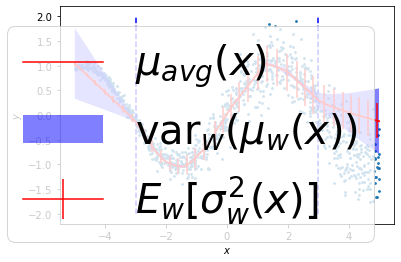

In [19]:
def plot_uncert(ax, inputs, targets, mean_mu=None, ale=None, epi=None):
    ax.scatter(inputs, targets, s=3)
    lower_x_bound = np.array([-3, -3])
    upper_x_bound = np.array([3, 3])
    y_bound = np.array([-2, 2])
    ax.plot(lower_x_bound, y_bound, "b--")
    ax.plot(upper_x_bound, y_bound, "b--")
    if mean_mu is not None:
        ax.plot(x, mean_mu, "r-", label="$\\mu_{avg}(x)$")
    if ale is not None:
        every_nth = 30
        ax.errorbar(x,
                    mean_mu,
                    np.sqrt(ale),
                    errorevery=every_nth,
                    color="r",
                    label="$E_w[\\sigma_w^2(x)]$")
        #ax.plot(x, ale, \"g-\", label=\"$E_w[\\sigma_w^2(x)]$\")
    if epi is not None:
        ax.fill_between(x,
                        mean_mu + np.sqrt(epi),
                        mean_mu - np.sqrt(epi),
                        facecolor="blue",
                        alpha=0.5,
                        label="var$_w(\\mu_w(x))$")
        #ax.plot(x, np.sqrt(100*epi))
    ax.legend(prop={'size': 40})
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

test_data_set = gaussian_sinus.GaussianSinus(range_=(-5, 5),
                                             store_file=Path("tmp_data"))
test_data = test_data_set.get_full_data(sorted_=True)


with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    ens_output = prob_ensemble.predict(x).cpu()
    z_mean, z_var = distilled_model.forward(x.to(device))
    z_mean, z_var = z_mean.cpu(), z_var.cpu()
    x = x.reshape(y.size())
    

mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
mean_mu_ens, mean_sigma_sq_ens = utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)
#mean_mu_ens = torch.mean(mu_ens, dim=1)
ale_ens, epi_ens = metrics.uncertainty_separation_parametric(mu_ens, sigma_sq_ens)

mu_dist = z_mean[:, 0]
ale_dist = torch.log( 1 + torch.exp(z_mean[:, 1]))
epi_dist = z_var[:, 1]
_, ax = plt.subplots()

_, true_mean, true_sigma = test_data_set.x_to_y_mapping(x)

#plot_uncert(ax, x, y, mean_mu=true_mean, ale=np.sqrt(true_sigma), epi=None)
#tikzplotlib.save("fig/toy_example/data.tikz")
plot_uncert(ax, x, y, mean_mu=mean_mu_ens, ale=ale_ens, epi=epi_ens)
#tikzplotlib.save("fig/toy_example/ensemble_mu_uncert.tikz")
#plot_uncert(ax, x, y, mean_mu=mu_dist, ale=ale_dist, epi=epi_dist)
#tikzplotlib.save("fig/toy_example/distilled_mu_uncert.tikz")

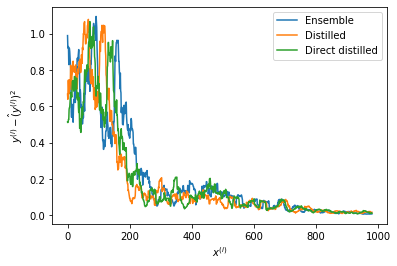

In [20]:
error = (y - mu_dist)**2
_, ax = plt.subplots()

window_size = 20
uncert_ens = ale_ens + epi_ens
uncert_dist = ale_dist + epi_dist
uncert_direct_dist = sigma_sq_dist

utils.plot_error_curve(ax,
                 y_true=y,
                 y_pred=mean_mu_ens,
                 uncert_meas=uncert_ens,
                 window_size=window_size,
                 label="Ensemble")

utils.plot_error_curve(ax,
                 y_true=y,
                 y_pred=mu_dist,
                 uncert_meas=uncert_dist,
                 window_size=window_size,
                 label="Distilled")

utils.plot_error_curve(ax,
                 y_true=y,
                 y_pred=mu_dist,
                 uncert_meas=uncert_direct_dist,
                 window_size=window_size,
                 label="Direct distilled")
ax.legend()
ax.set_xlabel("$x^{(i)}$")
ax.set_ylabel("$y^{(i)} - \hat(y^{(i)})^2$")
tikzplotlib.save("fig/toy_example/error_ord.tikz")

In [60]:
test_data_set = gaussian_sinus.GaussianSinus(range_=(-5, 5),
                                             store_file=Path("tmp_data"))
test_data = test_data_set.get_full_data(sorted_=True)

with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    output = prob_ensemble.predict(x)
mu_ens, sigma_sq_ens = ens_output[:, :, 0],  ens_output[:, :, 1]
mean_mu_ens, mean_sigma_sq_ens = utils.gaussian_mixture_moments(mu_ens, sigma_sq_ens)

gauss_param = (mean_mu_ens.unsqueeze_(1), mean_sigma_sq_ens.unsqueeze_(1))
mixture_targets = (mu_ens, sigma_sq_ens)
custom_loss.kl_div_gauss_and_mixture_of_gauss(gauss_param, mixture_targets)

2020-02-17 20:07:58,673 INFO  GaussianSinus   - Sampling new data
bar torch.Size([1000, 1]) mu_gauss torch.Size([1000, 1]) mix torch.Size([1000, 10])


tensor([-0.2040])

In [54]:
print(mean_mu_ens.shape)
print(mean_sigma_sq_ens.shape)
mu_bar = mu_ens.mean(dim=1, keepdim=True)
qu = (mu_ens - mu_bar)**2
print("qu", qu.shape)
num = sigma_sq_ens + qu
print("num", num.shape)
mean_num = torch.mean(num, dim=1, keepdim=True)
print("mean_num", mean_num.shape)
print("mean_sigma_sq_ens", mean_sigma_sq_ens.shape)
loss_all = mean_num / mean_sigma_sq_ens.unsqueeze_(1)



torch.Size([1000])
torch.Size([1000, 1, 1])
qu torch.Size([1000, 10])
num torch.Size([1000, 10])
mean_num torch.Size([1000, 1])
mean_sigma_sq_ens torch.Size([1000, 1, 1])


tensor(2.7943)

In [63]:
#Create distilled!
hidden_size = 10
distilled_output_size = ensemble_output_size
layer_sizes = [input_size, hidden_size, hidden_size, distilled_output_size]
gauss_mix_distilled = gauss_mix.Model(layer_sizes=layer_sizes,
                                      teacher=prob_ensemble,
                                      loss_function=custom_loss.kl_div_gauss_and_mixture_of_gauss,
                                      device=device)
gauss_mix_distilled.optimizer = torch.optim.Adam(gauss_mix_distilled.parameters(),
                                                 lr=args.lr)

# Retrain!
lower = -5
upper = 5
unlabelled_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=0)


gauss_mix_distilled.train(unlabelled_loader, 50)



2020-02-17 20:10:06,823 WARNING Model           - Must assign proper loss function to child.loss.
2020-02-17 20:10:06,824 INFO  Model           - Moving model to device: cuda
2020-02-17 20:10:06,825 INFO  Model           - Using variance transform: <lambda>
2020-02-17 20:10:06,826 INFO  GaussianSinus   - Sampling new data
2020-02-17 20:10:07,054 INFO  Model           - Training distilled network.
2020-02-17 20:10:08,309 INFO  Model           - Epoch 1: Loss: 9.756788611412048
2020-02-17 20:10:09,111 INFO  Model           - Epoch 2: Loss: 7.920641854405403
2020-02-17 20:10:09,901 INFO  Model           - Epoch 3: Loss: 6.769370332360268
2020-02-17 20:10:10,724 INFO  Model           - Epoch 4: Loss: 5.172164449468255
2020-02-17 20:10:11,528 INFO  Model           - Epoch 5: Loss: 3.1891974676400423
2020-02-17 20:10:12,362 INFO  Model           - Epoch 6: Loss: 1.2181899324059486
2020-02-17 20:10:13,177 INFO  Model           - Epoch 7: Loss: -0.7536483760923147
2020-02-17 20:10:13,987 INFO 

2020-02-17 20:11:23,501 INFO  GaussianSinus   - Sampling new data


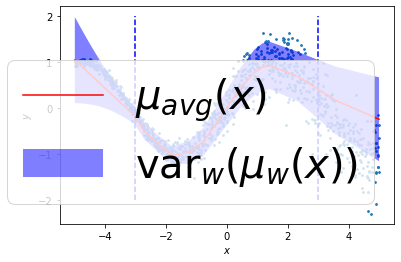

In [64]:

test_data_set = gaussian_sinus.GaussianSinus(range_=(-5, 5),
                                             store_file=Path("tmp_data"))
test_data = test_data_set.get_full_data(sorted_=True)


with torch.no_grad():
    x = torch.tensor(test_data[:, 0]).float()
    y = torch.tensor(test_data[:, 1]).float()
    x = x.reshape((len(x), 1))
    mu_dist, sigma_sq_dist = gauss_mix_distilled.forward(x.to(device))
    mu_dist, sigma_sq_dist = mu_dist.cpu().reshape(y.size()), sigma_sq_dist.cpu().reshape(y.size())
    x = x.reshape(y.size())
    

_, ax = plt.subplots()
plot_uncert(ax, x, y, mean_mu=mu_dist, ale=None, epi=sigma_sq_dist)
tikzplotlib.save("fig/toy_example/direct_distilled_mu_uncert.tikz")